# FULL NOT SPLIT 3CLS, 5CLS TRAINING / 3 CLS 기준으로 METRIC (AUROC및 ROC CURVE) 계산
* 5 fold의 mean 계산

In [1]:
import os
import numpy as np
import pandas
from sklearn.preprocessing import label_binarize
from scipy import interp
import re
from sklearn.metrics import roc_curve, auc
from collections import Counter
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt


# ENV SETTING

In [5]:
# true label env (3 classes 기준)
true_dataset_root = 'E:/Thesis_research/Database/Medical/Dental_directory_dataset'
true_lbl_dir = os.path.join(true_dataset_root, 'ClassificationClass','3classes')

# prediction env
pred_root = 'E:/Thesis_research/results_materials/Dental/raw_prediction_results/5e-5/logits_prediction_for_AUC'
train_cls_list = ['3classes', '5classes']
num_fold = 5
part_list = [16,26,36,46]
n_classes = 3
mean_fpr = np.linspace(0, 1, 500)

# ROC curve 그리기 위한 정보들 계산 (TPR, FPR)

In [6]:
tpr = dict()
fpr = dict()
n_classes = 3
tprs_all = dict()
for i_train_cls in train_cls_list:
    tprs_all[i_train_cls] = dict()
    for i_fold in range(num_fold):
        tprs_all[i_train_cls][i_fold] = dict()
        exp_name = f'resnet152-TL_aug-{i_train_cls}-fold{i_fold}'
        pred_dir = os.path.join(pred_root, exp_name, 'prediction_logits')
        
        # True label과 pred 모으기 (** 5 cls pred는 3cls 기준으로 바꾸기) 
        part_pred_list = []
        part_true_lbl_list = []
        part_name_list = []
        for i_pred in sorted(os.listdir(pred_dir)):
            part_name_list.append(os.path.splitext(i_pred)[0])
            pred_path = os.path.join(pred_dir, i_pred)
            true_lbl_path = os.path.join(true_lbl_dir, i_pred)
            
            # fill true lbl list (3 classes)
            with open(true_lbl_path, 'r') as f:
                part_true_lbl_list.append(int(f.read()))
            
            # fill pred list (softmax output)
            with open(pred_path, 'r') as f:
                part_pred_str = f.read()
                part_pred = list(map(float, part_pred_str[1:-1].split()))
                if i_train_cls =='5classes': # convert into 3classes pred
                    part_pred = [part_pred[0], np.sum(part_pred[1:3]), part_pred[4]]
                part_pred_list.append(part_pred)
        
        # 각 class 별로 threshold 구성 및 tpr, fpr 계산하기
        part_true_lbl_list = label_binarize(part_true_lbl_list, classes=[0, 1, 2]) # binarize label
        for i_class in range(n_classes): #positive class: current class!!
            tprs_all[i_train_cls][i_fold][i_class] = []

            # get thresh from sklearn roc_curve function
            tpr_part, fpr_part, thresh = roc_curve(np.array(part_true_lbl_list)[:, i_class], np.array(part_pred_list)[:, i_class])

            # construct (part) true and pred for target class
            part_true_lbl_cur_cls_list = []
            part_pred_score_cur_cls_list = []
            for i in range(len(part_true_lbl_list)):
                part_true_lbl_cur_cls_list.append(part_true_lbl_list[i][i_class])
                part_pred_score_cur_cls_list.append(part_pred_list[i][i_class])
            
            tpr_cur_cls = []
            fpr_cur_cls = []
            tpr_cur_cls.append(0)
            fpr_cur_cls.append(0)
            
            # 각 thresh별로 part pred cls list만들고 이를 이용해서 paitent-wise voting후 paitient-wise tpr, fpr로 roc curve 그리기!
            for i_thresh in tqdm(thresh[1:]):
                ######### voting framework !!! ##########
                # construct part_pred_cls
                part_pred_cls_cur_cls_list = []
                for i_part_pred_score_cur_cls in part_pred_score_cur_cls_list:
                    if i_part_pred_score_cur_cls >= i_thresh:
                        part_pred_cls_cur_cls_list.append(1)
                    else:
                        part_pred_cls_cur_cls_list.append(0)
                # construct all person num
                person_num_list = []
                for i_part_name in part_name_list:
                    part_name_info = i_part_name.split('_')
                    if len(part_name_info) > 1: # skip blank line
                        person_num_list.append(part_name_info[1])
                person_num_unique_list, unique_idx = np.unique(np.array(person_num_list), return_index=True)
                true_lbl_unique = np.array(part_true_lbl_cur_cls_list)[unique_idx]
                
                person_num_perdiction_all_list = []
                for i_iter, i_person_num_unique in enumerate(person_num_unique_list):
                    # 각 personnum을 포함하는 index를 part_name_list에서 찾아서 part_pred_cls_cur_cls_list에서 가져와야한다!!
                    person_num_idx = np.flatnonzero(np.core.defchararray.find(part_name_list,i_person_num_unique)!=-1)
                    preson_num_prediction = list(np.array(part_pred_cls_cur_cls_list)[person_num_idx])
                    person_num_perdiction_all_list.append(preson_num_prediction)
                    
                network_final_pred_list = []
                for i_person_num_pred in person_num_perdiction_all_list:
                    most_common_pred, num_most_common_pred = Counter(i_person_num_pred).most_common(1)[0]  # 4, 6 times
                    network_final_pred_list.append(most_common_pred)

                # Calculate tpr and fpr (network_final_pred_list vs true_lbl_unique)
                # positive: target calss (lbl = 1)
                num_total_sample = true_lbl_unique.shape[0]
                pos_lbl_idx = np.where(true_lbl_unique == 1)[0] 
                pos_lbl_num = pos_lbl_idx.shape[0] # TP + FN
                
                neg_lbl_idx = np.where(true_lbl_unique == 0)[0] 
                neg_lbl_num = neg_lbl_idx.shape[0] # FP + TN
                if (neg_lbl_num != (num_total_sample - pos_lbl_num)): 
                    raise AssertionError()
                
                tp_cur_thresh = np.where(np.array(network_final_pred_list)[pos_lbl_idx] == 1)[0].shape[0]
                tpr_cur_thresh = tp_cur_thresh / pos_lbl_num
                
                fp_cur_thresh = np.where(np.array(network_final_pred_list)[neg_lbl_idx] == 1)[0].shape[0]
                fpr_cur_thresh = fp_cur_thresh / neg_lbl_num 
                
                tpr_cur_cls.append(tpr_cur_thresh)
                fpr_cur_cls.append(fpr_cur_thresh)
             
            tprs_all[i_train_cls][i_fold][i_class].append(interp(mean_fpr,fpr_cur_cls, tpr_cur_cls)) ### WARNING: 이거 좀 의심됨... 일단 끝까지 해보자...
            tprs_all[i_train_cls][i_fold][i_class][-1][0] = 0.0
            
np.save("tprs_all.npy", tprs_all)     

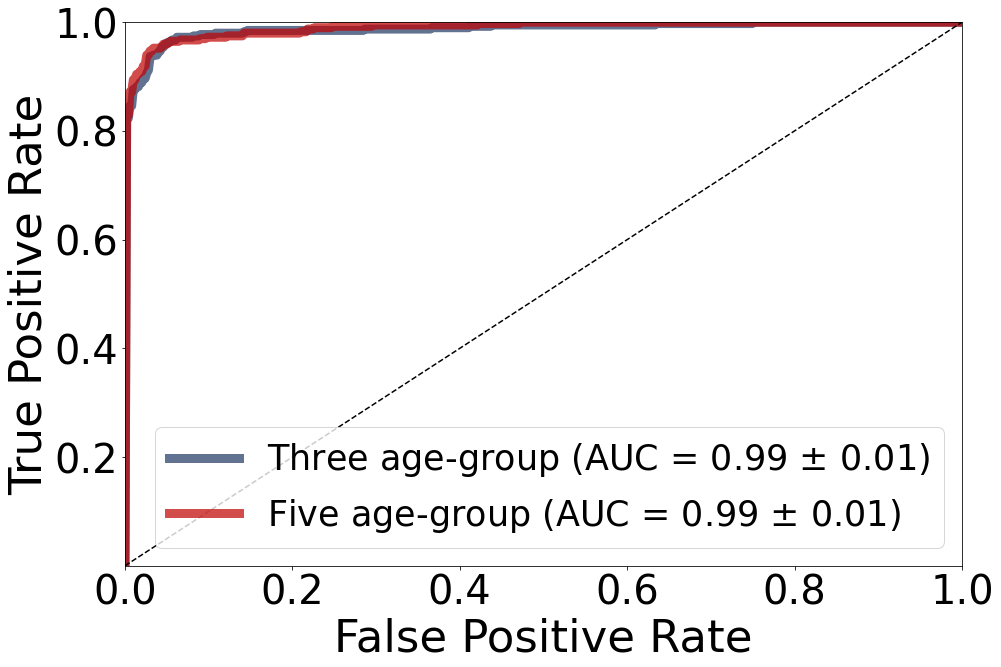

====== p-value =====
p-value 0.7309086682138292



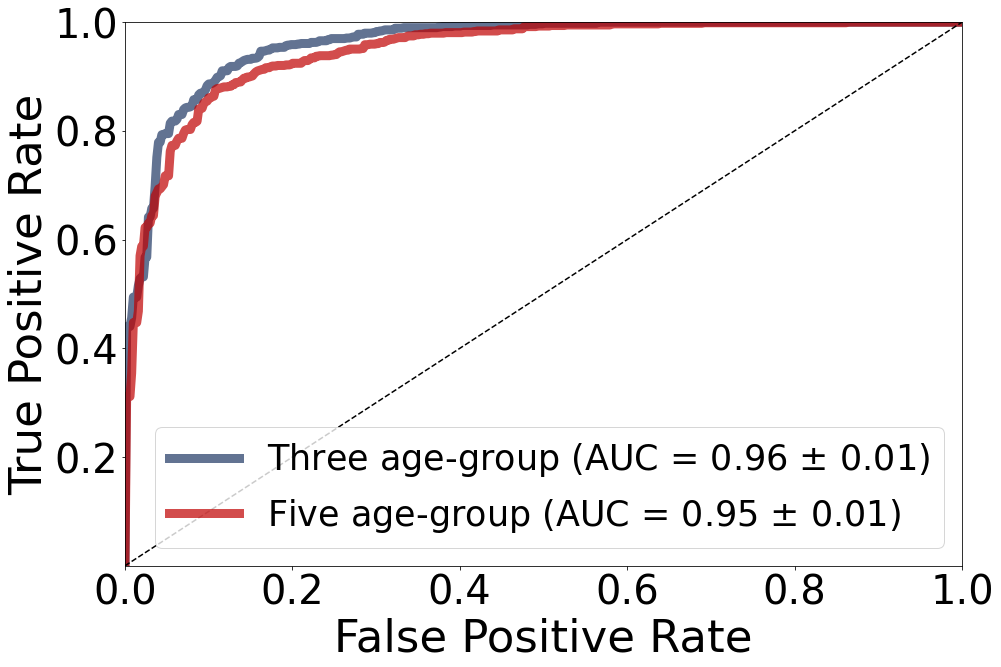

====== p-value =====
p-value 0.14214233235652832



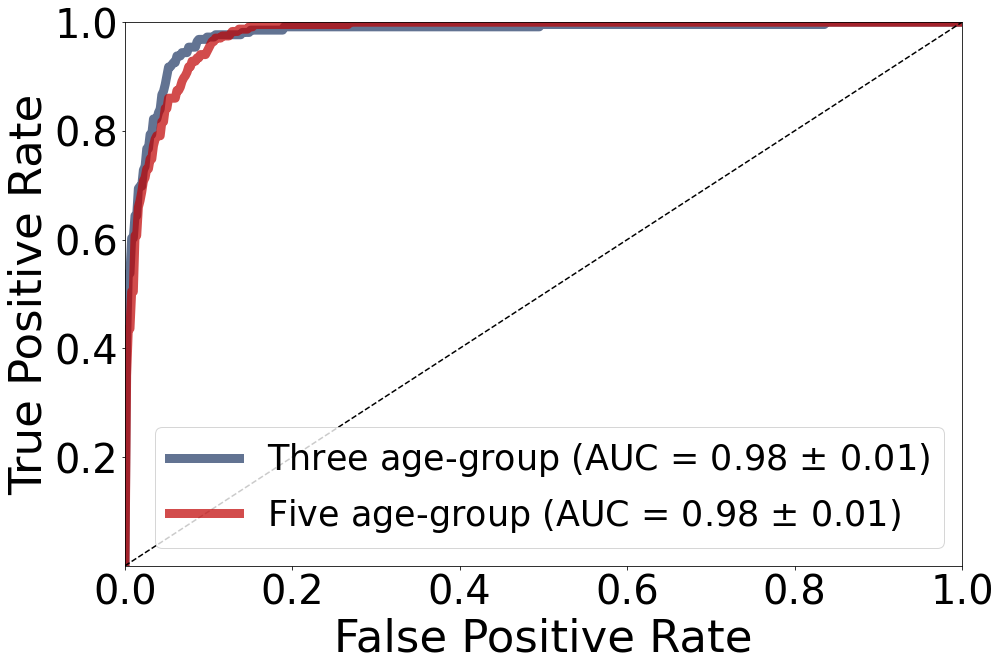

====== p-value =====
p-value 0.9620793212461293



In [8]:
label_fontsize = 45
tick_fontsize= 40
legend_fontsize = 35


from scipy.stats import ttest_ind
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10


tprs_all = np.load('tprs_all.npy', allow_pickle=True).item()
age_group_list = ['Positive class: Ages 0-19', 'Positive class: Ages 20-49', 'Positive class: Ages over 50']

train_class_list = ['Three age-group', 'Five age-group']
# color_list = ['cornflowerblue', 'darkorange']
# color_list = ['b', 'darkorange']
color_list = [(32/255, 56/255, 100/255),(192/255, 0, 0)]


for i_class in range(n_classes):
    fig, ax = plt.subplots()
    
    auc_all_dict = {}
    for i_cls_iter, i_train_cls in enumerate(train_cls_list):
        tprs_allFold = []
        aucs_allFold = []
        # 같은 class, train_cls 끼리 fold 정보들 모으기
        for i_fold in range(num_fold):
            tprs_allFold.append(tprs_all[i_train_cls][i_fold][i_class][0])
            roc_auc_eachFold = auc(mean_fpr, tprs_all[i_train_cls][i_fold][i_class][0])
            aucs_allFold.append(roc_auc_eachFold)
            
        auc_all_dict[i_train_cls] = aucs_allFold
        mean_tpr = np.mean(tprs_allFold, axis=0)
        mean_tpr[-1] = 1.0
#         mean_auc = auc(mean_fpr, mean_tpr)
        mean_auc = np.mean(aucs_allFold)
        std_auc = np.std(aucs_allFold)
        ax.plot(mean_fpr, mean_tpr, color=color_list[i_cls_iter],label='%s (AUC = %0.2f $\pm$ %0.2f)' % (train_class_list[i_cls_iter], mean_auc, std_auc), lw=9, alpha=.7)
#         plt.plot(mean_fpr, mean_tpr, color='b',label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), lw=2, alpha=.8)
    
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xticks(fontsize=tick_fontsize)
    plt.yticks([0.2,0.4,0.6,0.8,1.0], fontsize=tick_fontsize)
    plt.xlabel('False Positive Rate', fontsize=label_fontsize)
    plt.ylabel('True Positive Rate', fontsize = label_fontsize)
#     plt.title(age_group_list[i_class], fontsize = 15)
    plt.legend(loc="lower right", fontsize=legend_fontsize)
    plt.savefig('ROC_curve_%s.png' % str(i_class), dpi=300, bbox_inches='tight')
    # plt.savefig('ROC_curve_%s.pdf' % str(i_class), bbox_inches='tight')

    plt.show()
        
    print('====== p-value =====')
    ttest,pval = ttest_ind(auc_all_dict['3classes'] ,auc_all_dict['5classes'], equal_var=False)
    print("p-value",pval)
    print()

        
        
            